In [173]:
import os
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.python.data import Dataset
from IPython import display
import math

from matplotlib import cm
from matplotlib import gridspec
from sklearn import metrics

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
### working path
working_dir = "/app"
working_dir = "C:/Users/edwardchen/Desktop/DataSets/201801_cbc"
# model print out
model_dir = "/Data/model/cbc_dnn/"
model_dir = "".join([working_dir, model_dir])
print(model_dir)

### external test set
external_train_file = "/Data/sample/external_train_cbc.csv"
external_train_file = "".join([working_dir, external_train_file])

external_test_file = "/Data/sample/external_test_cbc.csv"
external_test_file = "".join([working_dir, external_test_file])

external_validate_file = "/Data/sample/external_validate_cbc.csv"
external_validate_file = "".join([working_dir, external_validate_file])

data_dir = "C:/git_src/cbc/Data/raw_data/cbc_csv_1_2"
data_dir = "/Data/raw_data/cbc_csv_1_2"
data_dir = "".join([working_dir, data_dir])

blast_count_dir = "C:/git_src/cbc/Data/raw_data/blast_count"
blast_count_dir = "/Data/raw_data/blast_count"
blast_count_dir = "".join([working_dir, blast_count_dir])

### user id data
user_info_dir = "C:/git_src/cbc/Data/raw_data/id_info"
user_info_dir = "/Data/raw_data/id_info"
user_info_dir = "".join([working_dir, user_info_dir])


C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/model/cbc_dnn/


In [4]:
def read_csv_from_dir(input_dir):
    abs_path_list = []
    cnt = 0
    for files in [item for item in os.walk(input_dir)]:
        cnt = cnt + 1
        #print("data directory #:{}".format(cnt))
        file_list = [file for file in files[2]]
        unflatten_list = [files[0]+"/"+file for file in file_list]
        file_cnt = 0
        for i in unflatten_list:
            file_cnt = file_cnt + 1
            #print("files count #:{}".format(file_cnt))
            abs_path_list.append(i)

    appended_data = []
    for file in abs_path_list:
        print("read file: {}".format(file))
        data = pd.read_csv(file, encoding="latin1")
        appended_data.append(data)
    appended_data = pd.concat(appended_data, axis=0)
    return appended_data

In [5]:
def remove_redundant_specimen_by_time(input_data, merge_buffer=3600):
    my_date_time = input_data['Analysis Date'].str.cat(input_data['Analysis Time'], sep = " ")
    my_date_time = pd.to_datetime(my_date_time, format='%m/%d/%Y %H:%M:%S')
    input_data_merge_time = input_data.assign(my_date_time = my_date_time)
    input_data_merge_time = input_data_merge_time.sort_values(by = ["Specimen_ID", "my_date_time"], ascending = False)
    input_data_merge_time['date_time_2'] = input_data_merge_time.groupby("Specimen_ID").my_date_time.shift(1)
    input_data_merge_time['time_difference'] = input_data_merge_time['date_time_2'] - input_data_merge_time['my_date_time']
    keep = (input_data_merge_time.loc[:, "time_difference"] > pd.Timedelta(merge_buffer, unit='s')) | pd.isnull(input_data_merge_time.loc[:, "time_difference"])
    return input_data_merge_time.loc[keep, :]

In [6]:
# input_data_merge_time.loc[keep, ["Specimen_ID", "my_date_time", 'date_time_2', 'time_difference', 'my_index']].sort_index()

In [7]:
CBC_data = read_csv_from_dir(data_dir)
blast_value = read_csv_from_dir(blast_count_dir)
user_info_df = read_csv_from_dir(user_info_dir)

read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201601/Patient_201601H(1)_IVD.csv


C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201601/Patient_2016h(2+3)_IVD.csv


C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (0,36,38,40,42,56,84,86,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201602/Patient_201602H(1)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201602/Patient_201602H(2+3)_IVD.csv


C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (0,36,38,42,84,86,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (36,38,40,42,56) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201603/Patient_2016-03H(1)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201603/Patient_2016-03H(2+3)_IVD.csv


C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (0,42,84,86,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (36,38,42) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201604/Patient_2016-04H(1)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201604/Patient_2016-04H(2+3)_IVD.csv


C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (0,40,42,56,84,86,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201605/Patient_2016-05H(1)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201605/Patient_2016-05H(2+3)_IVD.csv


C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (0,36,38,42) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (36,38,86) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201606/Patient_2016-06H(1)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201606/Patient_2016-06H(2+3)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201607/Patient_2016-07H(1)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201607/Patient_2016-07H(2+3)_IVD.csv


C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (36,38,85,87,89,91) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201608/Patient_2016-08(H1)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201608/Patient_2016-08H(2+3)_IVD.csv


C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (36,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201609/Patient_2015DxH(2+3)_IVD.csv


C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (40,42,56,84,86,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201609/Patient_201609H(1)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201609/Patient_201609H(2+3)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201610/Patient_201610H(1)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201610/Patient_201610H(2+3)_IVD.csv

C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (42,84,86,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (36,38,42,84,86,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):



read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201611/Patient_2016-11H(1)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201611/Patient_2016-11H(2+3)_IVD.csv


C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (0,1,36,38,42,84,86,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201612/Patient_2011612H(1)_IVD.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/cbc_csv_1_2\201612/Patient_201612H(2+3)_IVD.csv


C:\Users\edwardchen\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (0,36,38,40,42,56,84,88,90,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/blast_count/labdata-Blast-2016.csv
read file: C:/Users/edwardchen/Desktop/DataSets/201801_cbc/Data/raw_data/id_info/2016-Barcode.csv


In [8]:
print("CBC_data:{}".format(CBC_data.shape))
print("blast_count:{}".format(blast_value.shape))
print("user_info:{}".format(user_info_df.shape))

CBC_data:(319839, 230)
blast_count:(1118, 7)
user_info:(294915, 2)


In [132]:
# CBC_data = CBC_bk.copy()

In [10]:
# CBC_data set_index
CBC_data = CBC_data.set_index(np.arange(CBC_data.shape[0]))

#CBC_data = CBC_bk.copy()
CBC_data = CBC_data.rename(columns={"Specimen ID":"Specimen_ID"})
CBC_data['Specimen_ID'] = CBC_data['Specimen_ID'].astype(str)
CBC_data = CBC_data.assign(my_index = CBC_data.index)  # for test
CBC_bk = CBC_data.copy()

In [133]:
### Duplicate data 
duplicated_label = CBC_data.duplicated(subset = ["Specimen_ID"], keep = False)
cbc_duplicated = CBC_data.loc[duplicated_label, :]
cbc_duplicated_merge = remove_redundant_specimen_by_time(input_data=cbc_duplicated)
cbc_unique = CBC_data.drop_duplicates(subset='Specimen_ID', keep=False, inplace=False)
CBC_data = pd.concat([cbc_duplicated_merge, cbc_unique], axis = 0)

In [134]:
print("cbc_duplicated:{}".format(cbc_duplicated.shape))
print("cbc_duplicated_merge:{}".format(cbc_duplicated_merge.shape))
print("cbc_unique:{}".format(cbc_unique.shape))
print("CBC_data:{}".format(CBC_data.shape))

cbc_duplicated:(39970, 231)
cbc_duplicated_merge:(23086, 234)
cbc_unique:(279869, 231)
CBC_data:(302955, 234)


### filtering

In [135]:
CBC_data = CBC_data.rename(columns={'Imm Grans 1':'Imm_Grans_1', 'Imm Grans 2':'Imm_Grans_2','Imm Grans 3':'Imm_Grans_3', 'NE#':'NE_c', 'LY#':'LY_c', 'MO#':'MO_c', 'EO#':'EO_c',
       'BA#':'BA_c', 'NRBC#':'NRBC_c'})
gender_one_hot = pd.get_dummies(CBC_data.Gender)
CBC_data = pd.concat(axis=1, objs=[CBC_data, gender_one_hot])

In [136]:
CBC_data["WBC"] = pd.to_numeric(CBC_data['WBC'], errors='coerce')
CBC_data["LY"] = pd.to_numeric(CBC_data['LY'], errors='coerce')
CBC_data["BA_c"] = pd.to_numeric(CBC_data['BA_c'], errors='coerce')
CBC_data["NRBC"] = pd.to_numeric(CBC_data['NRBC'], errors='coerce')
CBC_data["NRBC_c"] = pd.to_numeric(CBC_data['NRBC_c'], errors='coerce')
CBC_data["MO_c"] = pd.to_numeric(CBC_data['NRBC'], errors='coerce')
CBC_data["NRBC_c"] = pd.to_numeric(CBC_data['NRBC_c'], errors='coerce')
CBC_data["MO_c"] = pd.to_numeric(CBC_data['MO_c'], errors='coerce')
CBC_data["EO_c"] = pd.to_numeric(CBC_data['EO_c'], errors='coerce')
CBC_data["Male"] = pd.to_numeric(CBC_data['Male'], errors='coerce')
CBC_data["Female"] = pd.to_numeric(CBC_data['Female'], errors='coerce')

In [137]:
left_shift_filter = CBC_data["Left Shift 3"]==0
wbc_filter = (CBC_data["WBC"] <= 10) & (CBC_data['WBC'] >= 4)
ly_filter = (CBC_data['LY'] <= 40) & (CBC_data['LY'] >= 20)
keep = left_shift_filter & wbc_filter & ly_filter

print("Dimension after filtering: {}".format(CBC_data.loc[keep, :].shape))

Dimension after filtering: (79270, 237)


In [138]:
# cbc_data_normal 指去除掉感染以及發炎的範圍
cbc_data_normal = CBC_data.loc[keep, :].copy()
print("去除感染的條件: {}".format(cbc_data_normal.shape))
print("原始未去除感染: {}".format(CBC_data.shape))

去除感染的條件: (79270, 237)
原始未去除感染: (302955, 237)


feature selection

In [139]:
### row filter
# normal case
input_data = cbc_data_normal

age_fil_unit = input_data["Age Unit"] == 'Years'
test_panel_fil_CD = (input_data['Test Panel'] == 'CD') | (input_data['Test Panel'] == 'CD RETIC')
age_fil = input_data["Age"] >= 30
row_filter = age_fil & age_fil_unit & test_panel_fil_CD

col_filter = ["Specimen_ID", "Gender", "Male", "Female", "Age", "Blast",'Imm_Grans_1', 'Imm_Grans_2','Imm_Grans_3',
            "WBC", "RBC", "HGB", "HCT", "MCV", "MCH", "MCHC", "RDW", "PLT", "MPV", "NE", "LY", 
            "MO", "EO", "BA", "NE_c", "LY_c", "MO_c", "EO_c", "BA_c", "NRBC", "NRBC_c"]
CBC_data_pa_normal = input_data[col_filter][row_filter.values].copy()

numeric_index = np.repeat(a=True, repeats=CBC_data_pa_normal.shape[0])
for i in range(3, 28):
#     print("round:", CBC_data_pa.columns[i])
    is_num = []
    CBC_data_pa_normal.iloc[:, i] = CBC_data_pa_normal.iloc[:, i].astype('str')
    for element in [element for element in CBC_data_pa_normal.iloc[:, i]]:
        element = str(element)[0]
#     for string in CBC_data_pa.iloc[:, i].str.get(0):
        tmp = element in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        #print("tmp:", tmp, "element:", element)
        is_num.append(tmp)
#     print(sum(is_num))
    numeric_index = [a and b for a, b in zip(numeric_index, is_num)]
CBC_data_pa_normal = CBC_data_pa_normal[numeric_index]

for i in range(3, 28):
    #print("round:", CBC_data_pa.columns[i])
    CBC_data_pa_normal.iloc[:, i] = CBC_data_pa_normal.iloc[:, i].astype('float')

In [140]:
### row filter
# All cases
input_data = CBC_data

age_fil_unit = input_data["Age Unit"] == 'Years'
test_panel_fil_CD = (input_data['Test Panel'] == 'CD') | (input_data['Test Panel'] == 'CD RETIC')
age_fil = input_data["Age"] >= 30
row_filter = age_fil & age_fil_unit & test_panel_fil_CD

col_filter = ["Specimen_ID", "Gender", "Male", "Female", "Age", "Blast",'Imm_Grans_1', 'Imm_Grans_2','Imm_Grans_3',
            "WBC", "RBC", "HGB", "HCT", "MCV", "MCH", "MCHC", "RDW", "PLT", "MPV", "NE", "LY", 
            "MO", "EO", "BA", "NE_c", "LY_c", "MO_c", "EO_c", "BA_c", "NRBC", "NRBC_c"]
CBC_data_pa = input_data[col_filter][row_filter.values].copy()

numeric_index = np.repeat(a=True, repeats=CBC_data_pa.shape[0])
for i in range(3, 28):
#     print("round:", CBC_data_pa.columns[i])
    is_num = []
    CBC_data_pa.iloc[:, i] = CBC_data_pa.iloc[:, i].astype('str')
    for element in [element for element in CBC_data_pa.iloc[:, i]]:
        element = str(element)[0]
#     for string in CBC_data_pa.iloc[:, i].str.get(0):
        tmp = element in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        #print("tmp:", tmp, "element:", element)
        is_num.append(tmp)
#     print(sum(is_num))
    numeric_index = [a and b for a, b in zip(numeric_index, is_num)]
CBC_data_pa = CBC_data_pa[numeric_index]

for i in range(3, 28):
    #print("round:", CBC_data_pa.columns[i])
    CBC_data_pa.iloc[:, i] = CBC_data_pa.iloc[:, i].astype('float')

In [141]:
print("去除感染的條件: {}".format(CBC_data_pa_normal.shape))
print("原始未去除感染: {}".format(CBC_data_pa.shape))

去除感染的條件: (63659, 31)
原始未去除感染: (173034, 31)


In [142]:
### Blast count 處理
accessnum_index = 3
blast_count_index = 5
blast_value_temp = blast_value.copy()
blast_value_temp.iloc[:, accessnum_index] = blast_value_temp.iloc[:, accessnum_index].str.replace(",","").str.replace(".","")
blast_value_temp = blast_value_temp.iloc[:, [accessnum_index, blast_count_index]]
blast_value_temp = blast_value_temp.rename(columns={"Accessnum":"Specimen_ID"})
blast_value_temp.shape

(1118, 2)

In [143]:
CBC_w_DC = pd.merge(left=CBC_data_pa, right=blast_value_temp, how='inner', on="Specimen_ID")
CBC_w_DC_normal = pd.merge(left=CBC_data_pa_normal, right=blast_value_temp, how='inner', on="Specimen_ID")

In [144]:
print("去除感染的條件: {}".format(CBC_w_DC_normal.shape))
print("原始未去除感染: {}".format(CBC_w_DC.shape))

去除感染的條件: (23, 32)
原始未去除感染: (744, 32)


資料集太小

In [145]:
# CBC_w_DC.to_csv("C:/Users/edwardchen/Desktop/cbc.csv")

In [146]:
# plt.scatter(CBC_w_DC['WBC'], CBC_w_DC['Result'])
# plt.show()

Data with blast count

In [147]:
CBC_data_haveBlast_all = CBC_w_DC.copy()
CBC_data_haveBlast_all = CBC_data_haveBlast_all.rename(columns={"Specimen ID":"Specimen_ID", "Result":"blast_count"})

In [148]:
CBC_data_haveBlast_all.shape

(744, 32)

data w/o blast count

In [149]:
col_filter = ["Specimen_ID", "Male", "Female", "Age", 
             "WBC", "RBC", "HGB", "HCT", "MCV", "MCH", "MCHC", "RDW", "PLT", "MPV", "NE", "LY", 
             "MO", "EO", "BA", "NE_c", "LY_c", "MO_c", "EO_c", "BA_c", "NRBC", "NRBC_c"]
CBC_wo_DC = pd.merge(left=CBC_data_pa.loc[:, col_filter], right=blast_value_temp, how='left', on="Specimen_ID")
CBC_wo_DC = CBC_wo_DC[CBC_wo_DC.Result.isna()]

In [150]:
print('CBC_data 大小:{}'.format(CBC_data_pa.shape))
print('w/o blast大小:{}'.format(CBC_wo_DC.shape))
print('差距應該要等於 CBC_data_haveBlast_all : {}'.format(CBC_data_pa.shape[0] - CBC_wo_DC.shape[0]))

CBC_data 大小:(173034, 31)
w/o blast大小:(172290, 27)
差距應該要等於 CBC_data_haveBlast_all : 744


In [151]:
CBC_wo_DC.Result = 0
CBC_wo_DC = CBC_wo_DC.rename(columns={'Result':'blast_count'})

In [152]:
CBC_data_noBlast_all = CBC_wo_DC.copy()

In [153]:
CBC_data_noBlast_all.shape

(172290, 27)

-. no blast external validation set

In [154]:
sample_count = CBC_data_haveBlast_all.shape[0]

In [155]:
'''
從Dataframe抽出sample_count數量的樣本
輸出: sample_count數量的records 和 剩下的其他records
'''
def simple_sampling(data_set, sample_count):
    data_count = data_set.shape[0]
    temp_index = np.random.choice(data_count, sample_count, replace=False)
    train_set = data_set.iloc[temp_index, :]
    test_set = data_set.drop(data_set.index[temp_index])
    result_obj = {"sample_set":train_set, "remain_set":test_set}
    return result_obj

In [156]:
temp_sampling_obj = simple_sampling(CBC_data_noBlast_all, sample_count)
no_blast_test_set = temp_sampling_obj['sample_set']
CBC_data_noBlast_all = temp_sampling_obj['remain_set']

In [157]:
no_blast_test_set.shape

(744, 27)

Sampling

In [158]:
def even_sampling(blast_data_frame, sample_ratio= [0.8], resampling_flag=True):
    
    ## Resampling ???
#     print("Resampling ...\n")    

    ### Even
    even_blast_obj = even_blast_level_with_validation_set(blast_data_frame, sample_ratio)
    blast_training = pd.concat(
        objs=[even_blast_obj['level_1_train_set'], even_blast_obj['level_2_train_set'], even_blast_obj['level_3_train_set']],
        axis=0)
    blast_validation = pd.concat(
        objs=[even_blast_obj['level_1_validate_set'], even_blast_obj['level_2_validate_set'], even_blast_obj['level_3_validate_set']],
        axis=0)
    blast_testing = pd.concat(
        objs=[even_blast_obj['level_1_test_set'], even_blast_obj['level_2_test_set'], even_blast_obj['level_3_test_set']],
        axis=0)

    result_obj = {
        "train_set" : blast_training,
        "validation_set" : blast_validation,
        "test_set" : blast_testing
    }

    return(result_obj)


In [159]:
def even_blast_level_with_validation_set(CBC_data_haveBlast_all, temp_ratio=[0.8]):
    # temp_ratio = c(0.8)
    data_L_1 = CBC_data_haveBlast_all[CBC_data_haveBlast_all.blast_count < 5]
    data_L_1 = data_L_1.assign(level=1)
    data_L_2 = CBC_data_haveBlast_all[(CBC_data_haveBlast_all.blast_count >= 5) & (CBC_data_haveBlast_all.blast_count < 20)]
    data_L_2 = data_L_2.assign(level=2)
    data_L_3 = CBC_data_haveBlast_all[CBC_data_haveBlast_all.blast_count >=20]
    data_L_3 = data_L_3.assign(level=3)

    min_count = min(data_L_1.shape[0], data_L_2.shape[0], data_L_3.shape[0],)
    sample_count = min_count * temp_ratio[0]
    sample_count = np.floor(sample_count)
    sample_count = int(sample_count)
    
    ### validation count
    validation_count = 0 
    if len(temp_ratio) > 1:
        temp_count = min_count * temp_ratio[1]
        validation_count = np.floor(temp_count)
        validation_count = int(validation_count)
    else:
        temp_count = (min_count * (1 - temp_ratio[0])) // 2
        validation_count = np.floor(temp_count)
        validation_count = int(validation_count)

    ### sampling
    data_count = data_L_1.shape[0]
    temp_set = simple_sampling(data_L_1, sample_count)
    level_1_train = temp_set['sample_set']
    remain_set = temp_set['remain_set']
    temp_set = simple_sampling(remain_set, validation_count)
    level_1_validate = temp_set['sample_set']
    level_1_test = temp_set['remain_set']

    data_count = data_L_2.shape[0]
    temp_set = simple_sampling(data_L_2, sample_count)
    level_2_train = temp_set['sample_set']
    remain_set = temp_set['remain_set']
    temp_set = simple_sampling(remain_set, validation_count)
    level_2_validate = temp_set['sample_set']
    level_2_test = temp_set['remain_set']

    data_count = data_L_3.shape[0]
    temp_set = simple_sampling(data_L_3, sample_count)
    level_3_train = temp_set['sample_set']
    remain_set = temp_set['remain_set']
    temp_set = simple_sampling(remain_set, validation_count)
    level_3_validate = temp_set['sample_set']
    level_3_test = temp_set['remain_set']

    result_obj = {
        "level_1_train_set" : level_1_train,
        "level_2_train_set" : level_2_train, 
        "level_3_train_set" : level_3_train,  
        "level_1_validate_set" : level_1_validate,
        "level_2_validate_set" : level_2_validate, 
        "level_3_validate_set" : level_3_validate,  
        "level_1_test_set" : level_1_test,
        "level_2_test_set" : level_2_test,
        "level_3_test_set" : level_3_test
        }

    return(result_obj)

In [160]:
sample_ratio = [0.8, 0.1]
resampling_flag = True

sampling_obj = even_sampling(blast_data_frame=CBC_data_haveBlast_all, sample_ratio=sample_ratio, resampling_flag=resampling_flag)
even_blast_training = sampling_obj['train_set']
even_blast_testing = sampling_obj['test_set']
even_blast_validation = sampling_obj['validation_set']

### record external data pipeline
# remain_set = record_external_data_pipeline(external_test_file, CBC_data_haveBlast_all, even_blast_testing)
# remain_set = record_external_data_pipeline(external_train_file, remain_set, even_blast_training)
# remain_set = record_external_data_pipeline(external_validate_file, remain_set, even_blast_validation)

In [161]:
print('training set: {}'.format(even_blast_training.shape))
print('testing set: {}'.format(even_blast_testing.shape))
print('validation set: {}'.format(even_blast_validation.shape))

training set: (411, 33)
testing set: (282, 33)
validation set: (51, 33)


Apply tensorflow modeling

In [163]:
def preprocess_features(even_blast_dataframe):

  selected_features = even_blast_dataframe[
    ["Male", "Female", 'Age', 'Blast', 'Imm_Grans_1', 'Imm_Grans_2',
       'Imm_Grans_3', 'WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDW',
       'PLT', 'MPV', 'NE', 'LY', 'MO', 'EO', 'BA', 'NE_c', 'LY_c', 'MO_c', 'EO_c',
       'BA_c', 'NRBC', 'NRBC_c']]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  return processed_features

def preprocess_targets(even_blast_dataframe):
  """
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["blast_count"] = even_blast_dataframe["blast_count"]
  return output_targets

In [164]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(even_blast_training)
training_targets = preprocess_targets(even_blast_training)

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(even_blast_validation)
validation_targets = preprocess_targets(even_blast_validation)

# Double-check that we've done the right thing.
print ("Training examples summary:")
display.display(training_examples.describe())
print ("Validation examples summary:")
display.display(validation_examples.describe())

print ("Training targets summary:")
display.display(training_targets.describe())
print ("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,Male,Female,Age,Blast,Imm_Grans_1,Imm_Grans_2,Imm_Grans_3,WBC,RBC,HGB,...,MO,EO,BA,NE_c,LY_c,MO_c,EO_c,BA_c,NRBC,NRBC_c
count,411.0,411.0,411.0,411.0,411.0,411.0,411.0,411.0,411.0,411.0,...,411.0,411.0,411.0,411.0,411.0,411.0,411.0,411.0,411.0,411.0
mean,0.4,0.6,67.8,0.7,0.6,0.6,0.7,19.3,2.9,8.3,...,24.5,1.6,0.9,7.5,3.9,1.0,0.3,0.2,1.0,0.1
std,0.5,0.5,13.8,0.5,0.5,0.5,0.5,44.1,0.7,1.9,...,25.6,5.0,2.3,26.4,18.1,4.3,3.2,1.1,4.3,0.5
min,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.1,0.6,1.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,58.0,0.0,0.0,0.0,0.0,1.9,2.4,7.2,...,4.2,0.1,0.1,0.4,0.7,0.1,0.0,0.0,0.1,0.0
50%,0.0,1.0,74.0,1.0,1.0,1.0,1.0,4.8,2.8,8.2,...,12.9,0.5,0.4,1.5,1.2,0.3,0.0,0.0,0.3,0.0
75%,1.0,1.0,77.0,1.0,1.0,1.0,1.0,11.7,3.3,9.4,...,37.9,1.2,0.9,5.5,2.0,0.7,0.1,0.1,0.7,0.0
max,1.0,1.0,91.0,1.0,1.0,1.0,1.0,465.0,5.3,13.4,...,97.6,85.8,27.9,413.9,189.8,57.3,57.6,12.3,57.3,6.2


Validation examples summary:


,Male,Female,Age,Blast,Imm_Grans_1,Imm_Grans_2,Imm_Grans_3,WBC,RBC,HGB,...,MO,EO,BA,NE_c,LY_c,MO_c,EO_c,BA_c,NRBC,NRBC_c
count,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,...,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0
mean,0.3,0.7,67.2,0.6,0.5,0.6,0.6,17.9,2.8,8.3,...,24.6,2.8,0.6,3.4,6.5,1.7,1.2,0.1,1.7,0.1
std,0.5,0.5,14.6,0.5,0.5,0.5,0.5,40.3,0.7,1.9,...,27.2,11.0,0.9,4.7,26.1,6.9,7.9,0.6,6.9,0.4
min,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.2,1.0,3.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,59.0,0.0,0.0,0.0,0.0,1.9,2.4,7.4,...,5.4,0.1,0.1,0.5,0.6,0.1,0.0,0.0,0.1,0.0
50%,0.0,1.0,74.0,1.0,1.0,1.0,1.0,4.0,2.9,8.4,...,13.9,0.1,0.3,1.2,1.1,0.3,0.0,0.0,0.3,0.0
75%,1.0,1.0,77.0,1.0,1.0,1.0,1.0,9.8,3.3,9.6,...,34.1,1.3,0.7,3.9,1.6,0.6,0.1,0.0,0.6,0.1
max,1.0,1.0,87.0,1.0,1.0,1.0,1.0,201.3,4.2,12.2,...,96.1,76.6,5.0,22.6,182.4,48.3,56.8,3.8,48.3,2.9


Training targets summary:


,blast_count
count,411.0
mean,19.5
std,23.2
min,1.0
25%,2.0
50%,9.0
75%,27.0
max,95.0


Validation targets summary:


,blast_count
count,51.0
mean,21.7
std,26.6
min,1.0
25%,2.0
50%,9.0
75%,33.0
max,95.0


觀察correaltion

In [165]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["blast_count"]

correlation_dataframe.corr()

,Male,Female,Age,Blast,Imm_Grans_1,Imm_Grans_2,Imm_Grans_3,WBC,RBC,HGB,...,EO,BA,NE_c,LY_c,MO_c,EO_c,BA_c,NRBC,NRBC_c,target
Male,1.0,-1.0,0.2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.0,-0.0,0.1,0.1,-0.0,0.0,-0.1
Female,-1.0,1.0,-0.2,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,...,-0.1,-0.1,-0.1,-0.0,0.0,-0.1,-0.1,0.0,-0.0,0.1
Age,0.2,-0.2,1.0,-0.1,0.0,-0.0,-0.1,-0.2,-0.2,-0.1,...,0.1,0.1,-0.1,-0.1,-0.0,-0.0,-0.0,-0.0,-0.1,-0.1
Blast,0.1,-0.1,-0.1,1.0,0.5,0.5,0.4,0.2,-0.1,-0.2,...,-0.2,0.0,0.1,0.1,-0.1,-0.0,0.1,-0.1,0.1,0.4
Imm_Grans_1,0.1,-0.1,0.0,0.5,1.0,0.9,0.8,0.2,0.0,-0.0,...,-0.1,0.0,0.2,-0.1,0.1,-0.0,0.1,0.1,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EO_c,0.1,-0.1,-0.0,-0.0,-0.0,-0.0,-0.0,0.3,0.0,0.0,...,0.8,0.0,0.4,0.0,-0.0,1.0,0.2,-0.0,0.3,-0.1
BA_c,0.1,-0.1,-0.0,0.1,0.1,0.1,0.1,0.3,0.2,0.1,...,0.1,0.5,0.5,0.0,-0.0,0.2,1.0,-0.0,0.1,-0.1
NRBC,-0.0,0.0,-0.0,-0.1,0.1,0.0,0.0,-0.0,-0.1,-0.0,...,0.1,0.0,-0.0,-0.0,1.0,-0.0,-0.0,1.0,0.5,-0.1
NRBC_c,0.0,-0.0,-0.1,0.1,0.2,0.1,0.1,0.6,-0.2,-0.2,...,0.0,-0.0,0.5,0.0,0.5,0.3,0.1,0.5,1.0,0.2


流程:

1. Build feature columns
2. Define input function
3. Define optimizer
4. Training model

In [166]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [167]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(100)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [168]:
def train_regression_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `cbc_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `cbc_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `cbc_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `cbc_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["blast_count"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["blast_count"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["blast_count"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print ("Training model...")
  print ("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print ("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print ("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()
  plt.show()

  return linear_regressor

開train

In [169]:
training_examples.loc[:,[ 'MCHC', 'RDW',
       'PLT', 'MPV', 'NE', 'LY',]].dtypes

MCHC    float64
RDW     float64
PLT     float64
MPV     float64
NE      float64
LY      float64
dtype: object

Training model...
RMSE (on training data):
  period 00 : 29.47
  period 01 : 29.02
  period 02 : 28.77
  period 03 : 28.45
  period 04 : 28.26
  period 05 : 28.28
  period 06 : 27.77
  period 07 : 27.44
  period 08 : 27.25
  period 09 : 27.19
Model training finished.


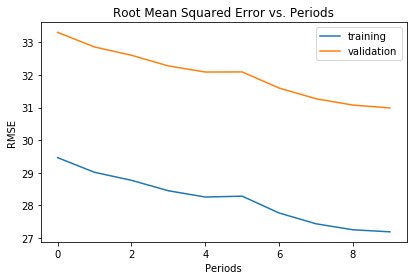

In [174]:
minimal_features = ['Male', 'Age', 'Blast', 'WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDW',
       'PLT', 'MPV', 'NE', 'LY', 'MO', 'EO', 'BA', 'NE_c', 'LY_c', 'MO_c',
       'EO_c', 'BA_c', 'NRBC', 'NRBC_c']

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

train_regression_model(
    learning_rate=0.0001,
    steps=200,
    batch_size=10,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 23.04
  period 01 : 19.60
  period 02 : 19.19
  period 03 : 21.25
  period 04 : 19.24
  period 05 : 21.77
  period 06 : 17.54
  period 07 : 17.54
  period 08 : 18.39
  period 09 : 18.07
Model training finished.


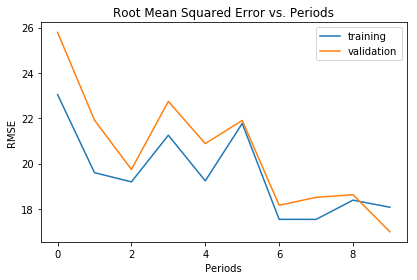

In [178]:
minimal_features = ['Male', 'Age', 'Blast', 'WBC', 'RBC', 'HGB', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDW',
       'PLT', 'MPV', 'NE', 'LY', 'MO', 'EO', 'BA', 'NE_c', 'LY_c', 'MO_c',
       'EO_c', 'BA_c', 'NRBC', 'NRBC_c']

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

linear_regressor = train_regression_model(
    learning_rate=0.01,
    steps=400,
    batch_size=10,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [180]:
test_examples = preprocess_features(even_blast_testing)
test_targets = preprocess_targets(even_blast_testing)

predict_test_input_data = lambda: my_input_fn(batch_size=1, features=test_examples, num_epochs=1, shuffle=False, targets=test_targets)

test_predictions = linear_regressor.predict(input_fn = predict_test_input_data)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print ("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 16.40


In [215]:
pd.concat(objs= [pd.Series(test_predictions, name='prediction'), test_targets], axis=1)#.to_csv("C:/Users/edwardchen/Desktop/predict.csv")

,prediction,blast_count
0,2.4,1.0
1,5.5,1.0
2,11.6,4.0
3,0.5,1.0
4,2.9,1.0
...,...,...
277,8.0,37.0
278,23.4,25.0
279,2.7,58.0
280,6.5,35.0
